In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex
import sympy
from sympy import *
from sympy.physics.units import *
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify

sympy.init_printing()

In [2]:
x, y, dx, dy = symbols("x y dx dy")
xdot, ydot = symbols("xdot ydot", cls=Function)
m = 4
xs = [symbols("x{}".format(i)) for i in range(m)]
ys = [symbols("y{}".format(i)) for i in range(m)]
drs = [symbols("dr{}".format(i)) for i in range(m)]


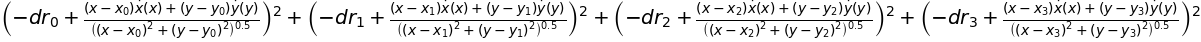

In [3]:
Es = [(xdot(x)*(x-xi)+ydot(y)*(y-yi))*((x-xi)**2 + (y-yi)**2)**(-1/2) - dri for xi, yi, dri in zip(xs, ys, drs)]
F = sum((E**2 for E in Es))
F

In [4]:
dxdtx = diff(xdot(x), x)
dydtx = diff(ydot(y), y)
dfdx = diff(F, x).subs(dxdtx, 0).subs(xdot(x), dx).subs(ydot(y), dy)
dfdy = diff(F, y).subs(dydtx, 0).subs(xdot(x), dx).subs(ydot(y), dy)
F = F.subs(xdot(x), dx).subs(ydot(y), dy)
F_fn = lambdify((x, y, dx, dy, *xs, *ys, *drs), F, "numpy")
dfdxdt = diff(F, dx)
dfdydt = diff(F, dy)
G = [dfdx, dfdy, dfdxdt, dfdydt] # gradient of F
G_fn = [lambdify((x, y, dx, dy, *xs, *ys, *drs), g, "numpy") for g in G]

In [5]:
xsubs=[1, 3, 1, 6]
ysubs=[6, 1, 0.5, 2]
rdotsubs=[-1.1860489971521626, -1.2982653874863912, -1.3793586660117907, -1.3002255874269588]

F_call = lambda zz: F_fn(*zz, *xsubs, *ysubs, *rdotsubs)
G_call = lambda zz: np.array([g_fn(*zz, *xsubs, *ysubs, *rdotsubs) for g_fn in G_fn])

In [6]:
minx = min(xsubs)-2
miny = min(ysubs)-2
maxx = max(xsubs)*1.1
maxy = max(ysubs)*1.1

bnds = ((minx, maxx), (miny, maxy), (minx, maxx), (miny, maxy))
zz0 = np.array([sum(xsubs)/len(xsubs), sum(ysubs)/len(ysubs), 0, 0])

rslts = minimize(F_call, zz0, method='SLSQP', jac=G_call)
print(rslts)
print(F_call(np.array([0, 0, 1, 1])))
print(F_call(rslts.x))

     fun: 0.005578680110684838
     jac: array([-7.10574504e-04,  7.21577163e-05,  4.58981735e-04, -1.83683376e-04])
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 17
    njev: 17
  status: 0
 success: True
       x: array([ 4.60059963, 10.7578816 , -0.21275899, -1.33601705])
0.005025256486806806
0.005578680110684838


In [7]:

import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from IPython.display import display, Markdown, Latex
import sympy
from sympy import *
from scipy.optimize import minimize
from sympy.utilities.lambdify import lambdify

class Solver(object):
    def __init__(self, sensor_poses):
        x, y, dx, dy = symbols("x y dx dy")
        xdot, ydot = symbols("xdot ydot", cls=Function)
        drs = [symbols("dr{}".format(i)) for i in range(len(sensor_poses))]
        
        self.zz0 = np.concatenate([sum(sensor_poses)/len(sensor_poses), np.array([0, 0])])
        
        # Per Sesnor Error Function
        Es = [(xdot(x)*(x-p[0])+ydot(y)*(y-p[1]))*((x-p[0])**2 + (y-p[1])**2)**(-1/2) - dri 
                   for p, dri in zip(sensor_poses, drs)]
        
        # Objective Function (total error)
        F = sum((E**2 for E in Es))
        
        dxdtx = diff(xdot(x), x)
        dydtx = diff(ydot(y), y)
        dfdx = diff(F, x).subs(dxdtx, 0).subs(xdot(x), dx).subs(ydot(y), dy)
        dfdy = diff(F, y).subs(dydtx, 0).subs(xdot(x), dx).subs(ydot(y), dy)
        F = F.subs(xdot(x), dx).subs(ydot(y), dy)
        self.F_fn = lambdify((x, y, dx, dy, *drs), F, "numpy")
        dfdxdt = diff(F, dx)
        dfdydt = diff(F, dy)
        G = [dfdx, dfdy, dfdxdt, dfdydt] # gradient of F
        self.G_fn = [lambdify((x, y, dx, dy, *drs), g, "numpy") for g in G]
        
        self.F = F
        self.G = G
    
    def get_objective_expr(self):
        return self.F
    
    def get_gradient_expr(self):
        return self.G
    
    # Returns (position estimate, velocity estimate)
    def find_min(self, drs, method='SLSQP', **args):
        F_call = lambda zz: self.F_fn(*zz, *drs)
        G_call = lambda zz: np.array([g_fn(*zz, *drs) for g_fn in self.G_fn])
        
            rslts = minimize(F_call, zz0, method=method, jac=G_call)
        
        return rslts.x[:2], rslts.x[2:]

In [16]:
s = Solver([np.array([1,6]), np.array([3,1]), np.array([1,0.5]), np.array([6,2])])

In [17]:
s.find_min([-1.1860489971521626, -1.2982653874863912, -1.3793586660117907, -1.3002255874269588])

(array([ 4.60059963, 10.7578816 ]), array([-0.21275899, -1.33601705]))